# **Introduction to Deep Learning: Final Project**

**Submitted by:**

Roei Matz       205871478

Yotam Silverman 313532418

## Project Description

The data for this project was gathered from the [sign language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset from the website kaggle.com.


The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.

Our project's objective is to design and build a neural network that will identify the letters given in each image.

## Setup

In [3]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

# CapsNet related imports
import os
import pandas as pd
from sklearn.metrics import accuracy_score
#

import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

Mount Google Drive and load the project's data:

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
train_csv = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_train.csv')
test_csv  = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_test.csv')
x_train_val = np.genfromtxt(train_csv, delimiter=',')[1:,1:]
x_test = np.genfromtxt(test_csv, delimiter=',')[1:,1:]

train_csv = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_train.csv')
test_csv  = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_test.csv')
t_train_val = np.genfromtxt(train_csv, delimiter=',')[1:,0]
t_test =  np.genfromtxt(test_csv, delimiter=',')[1:,0]

Mounted at /content/gdrive


Splitting the train set to train and validation

In [5]:
x_train = x_train_val[0:round(0.8*len(x_train_val))]
x_val = x_train_val[round(0.8*len(x_train_val)):]

t_train = t_train_val[0:round(0.8*len(t_train_val))]
t_val = t_train_val[round(0.8*len(t_train_val)):]

Making a dictionary for the alphabet:

In [6]:
import string
alphabet_dict = dict(zip(range(0,26),string.ascii_uppercase))

print(alphabet_dict)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


Here, we show few examples of the letters notions in the sign language:

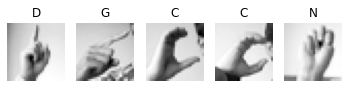

In [7]:
plt.figure(figsize=(6, 3))
for i in range(0,5): 
  plt.subplot(1, 5, i + 1)
  img = x_train[i]
  img = np.reshape(img, (28, 28))
  plt.imshow(img, cmap='Greys_r')
  plt.title(alphabet_dict[int(t_train[i])])
  plt.axis('off');

Normalizing the data set:

In [8]:
def img_norm(data):
  output = []
  for img in data: 
    img = (img - np.mean(img))/np.std(img)  #zero mean and a unit standard deviation
    output.append(np.array(img))
  return np.array(output)

# def img_norm(data): # 63% accuracy
#   output = []
#   for img in data: 
#     img = img/255                        #pixels' values between 0 to 1
#     output.append(np.array(img))
#   return np.array(output)

# def img_norm(data): # 78% accuracy
#   output = []
#   for img in data: 
#     img = img/255 - 0.5                 #pixels' values between -0.5 to 0.5
#     output.append(np.array(img))
#   return np.array(output)

x_train_norm = img_norm(x_train)
x_val_norm = img_norm(x_val)
x_test_norm = img_norm(x_test)

train_loader = torch.utils.data.DataLoader(
    np.concatenate((t_train[:,None], x_train_norm),axis=1),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    np.concatenate((t_val[:,None], x_val_norm),axis=1),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    np.concatenate((t_test[:,None], x_test_norm),axis=1),
    batch_size=64, shuffle=True)

After checking the network with several normalztions techniques, such as: dividing each image by 255 so we will have values between 0 and 1, and also subtracting 0.5 so that the elements of will be between -0.5 and 0.5, we chose to normalize by subtracting the mean of each image and dividing the standard deviation. This normaliztion provided the best accuracy with our models.

Defining CNN:

In [9]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, output_size)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

def get_accuracy(model, loader=train_loader):
    model.eval()
    loss = 0
    correct = 0
    pred_list = []
    true_list = []
    for ar in loader:
        data = ar[:,1:]
        label = ar[:,0]
        # send to device
        data, label = data.to(device), label.to(device)
        
        data = data.view(-1, 28*28)
        data = data.view(-1, 1, 28, 28)
        pred = model(data)
        loss += F.nll_loss(pred, label.long(), reduction='sum').item() # sum up batch loss                                                               
        pred = pred.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()
 
        for y in pred.squeeze(1):
          pred_list.append(y.cpu())

        for y in label:  
          true_list.append(y.cpu())
          
    conf_mat = confusion_matrix(true_list, pred_list, labels=list(range(0,9))+list(range(10,25)))    
    loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    
    return loss, accuracy, conf_mat

def show_confusion_matrix(conf_mat):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[alphabet_dict[i] for i in list(range(0,9))+list(range(10,25))])
    fig, ax = plt.subplots(figsize=(14, 12))
    ax.set_xlabel('Preicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16) 
    disp.plot(ax=ax)

def train(model, lr=0.01, max_iters=1000,num_epochs=6):
    model.train()
    train_accs, valid_accs = [], []
    epochs = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    n = 0 # the number of iterations
    iters, losses = [], []
    iters_sub = []

    for epoch in range(0, num_epochs):

        for batch_idx, ar in enumerate(train_loader):           
            data = ar[:,1:]
            label = ar[:,0]
            # send to device
            data, label = data.to(device), label.to(device)
            data = data.view(-1, 28*28)
            data = data.view(-1, 1, 28, 28)

            optimizer.zero_grad()
            pred = model(data)
            loss = F.nll_loss(pred, label.long())
            loss.backward()
            optimizer.step()

            iters.append(n)
            losses.append(loss)

            if batch_idx % 64 == 0: 
                
                iters_sub.append(n)
                train_loss, train_acc, _ = get_accuracy(model, loader=train_loader)
                train_accs.append(train_acc)

                valid_loss, valid_acc, _ = get_accuracy(model, loader=val_loader)
                valid_accs.append(valid_acc)
      
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (n, valid_acc, train_acc, train_loss))

            # increment the iteration number
            n += 1
            if n > max_iters:
                return iters, losses, iters_sub, train_accs, valid_accs
    return iters, losses, iters_sub, train_accs, valid_accs
            


In [10]:
# Training settings 
n_features = 10 # number of feature maps

input_size  = 28*28   # images are 28x28 pixels
output_size = 26      # there are 26 classes

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)

lr = 0.001
momentum = 0.1

iters, losses, iters_sub, train_accs, valid_accs = train(model_cnn.double(), lr=lr, max_iters=640,num_epochs=6)

Iter 0. [Val Acc 6%] [Train Acc 6%, Loss 3.265174]
Iter 64. [Val Acc 41%] [Train Acc 41%, Loss 1.910137]
Iter 128. [Val Acc 64%] [Train Acc 64%, Loss 1.143747]
Iter 192. [Val Acc 76%] [Train Acc 75%, Loss 0.779025]
Iter 256. [Val Acc 82%] [Train Acc 82%, Loss 0.551538]
Iter 320. [Val Acc 88%] [Train Acc 89%, Loss 0.397193]
Iter 344. [Val Acc 82%] [Train Acc 83%, Loss 0.476390]
Iter 408. [Val Acc 92%] [Train Acc 93%, Loss 0.263647]
Iter 472. [Val Acc 94%] [Train Acc 94%, Loss 0.208275]
Iter 536. [Val Acc 96%] [Train Acc 96%, Loss 0.165762]
Iter 600. [Val Acc 96%] [Train Acc 97%, Loss 0.127989]


We plot the learning curves: the training loss curve and the training and validation accuracies curves.

In [11]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    if (len(val_accs) > 0):
      plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

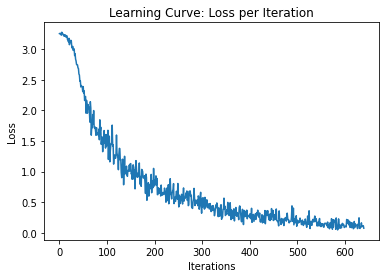

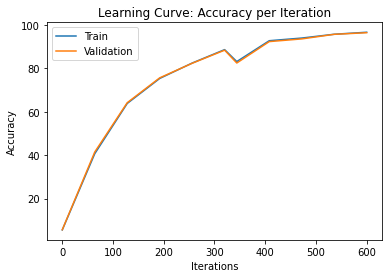

In [12]:
plot_learning_curve(iters, losses, iters_sub, train_accs, valid_accs)

We check our model performance by calculating the loss and the accuracy of the model with the test set.

Test set: Average loss: 0.421534, Accuracy: 88%


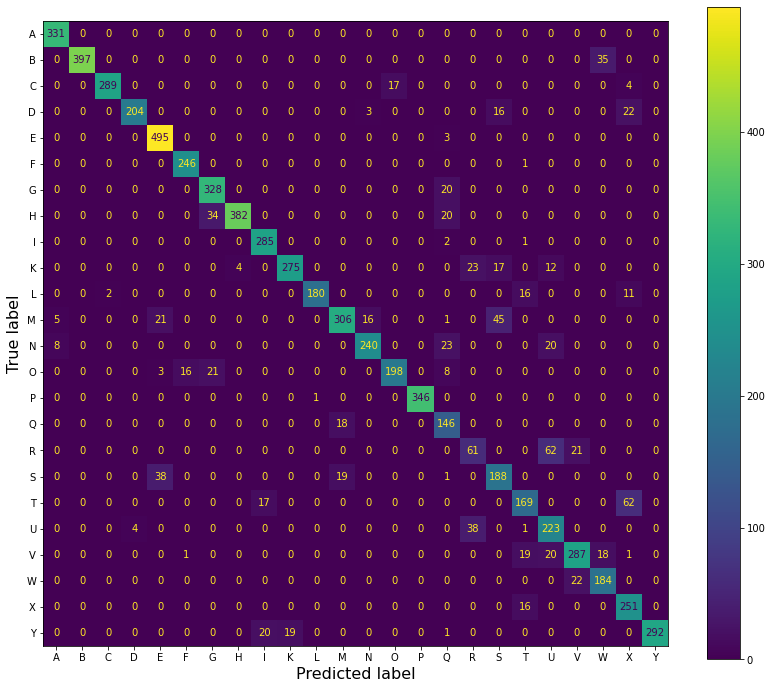

In [13]:
test_loss, test_acc, cnn_test_conf_mat = get_accuracy(model_cnn,loader=test_loader)
print("Test set: Average loss: %f, Accuracy: %.0f%%" % (test_loss,test_acc)) 
show_confusion_matrix(cnn_test_conf_mat)

Displaying some of our results:

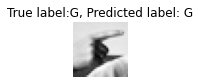

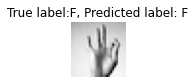

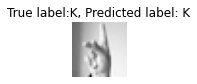

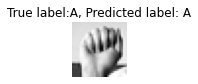

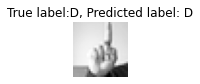

In [14]:
num_of_samples = 5
for i in range(0,num_of_samples):
  data = x_test_norm[i]
  img = np.reshape(data, (28, 28)) 
  data = torch.Tensor(data).view(-1, 28*28)
  data = data.view(-1, 1, 28, 28) 
  pred = model_cnn(data.double().to(device))
  pred = pred.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                  
  plt.figure(figsize=(2, 1))
  plt.imshow(img, cmap='Greys_r')
  plt.title(f"True label:{alphabet_dict[int(t_test[i])]}, Predicted label: {alphabet_dict[int(pred)]}")
  plt.axis('off');

## LeNet5

LeNet5 is a well-known multi-layer convolution neural network architecture, introduced in 1989 in a paper by Yann LeCun and his team [1]. This network is composed of 3 convolutional layers, with the *tanh()* activation function and an average pooling layer between them. Following these layers, we have 2 fully-connected layers - the first with the *tanh()* activation function and the output layer with the *softmax()*/*log_softmax()* activation function.

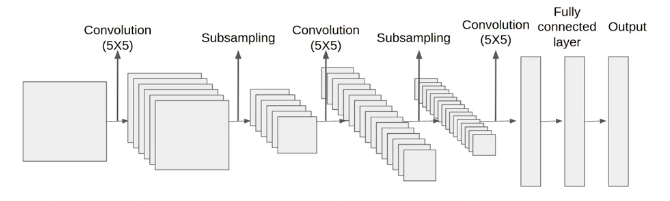

*An illustration of a LeNet5 architecture, taken from [2]*



In [15]:

class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.tanh = nn.Tanh()
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=480, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=26)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avgpool2(x)
        x = self.conv3(x)
        x = self.tanh(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

Now, we'll train our LeNet5 model, plot the learning curve and print the test accuracy and confusion matrix:

In [16]:
model_lenet = LeNet5()
model_lenet.to(device)

lr = 0.001

iters, losses, iters_sub, train_accs, valid_accs = train(model_lenet.double(), lr=lr, max_iters=1000,num_epochs=10)

Iter 0. [Val Acc 9%] [Train Acc 9%, Loss 3.227117]
Iter 64. [Val Acc 54%] [Train Acc 53%, Loss 1.706441]
Iter 128. [Val Acc 69%] [Train Acc 69%, Loss 1.212079]
Iter 192. [Val Acc 76%] [Train Acc 77%, Loss 0.908497]
Iter 256. [Val Acc 84%] [Train Acc 85%, Loss 0.672276]
Iter 320. [Val Acc 90%] [Train Acc 90%, Loss 0.521486]
Iter 344. [Val Acc 90%] [Train Acc 91%, Loss 0.463298]
Iter 408. [Val Acc 93%] [Train Acc 94%, Loss 0.356458]
Iter 472. [Val Acc 96%] [Train Acc 96%, Loss 0.268980]
Iter 536. [Val Acc 97%] [Train Acc 98%, Loss 0.199263]
Iter 600. [Val Acc 98%] [Train Acc 99%, Loss 0.156678]
Iter 664. [Val Acc 99%] [Train Acc 99%, Loss 0.120539]
Iter 688. [Val Acc 99%] [Train Acc 99%, Loss 0.113586]
Iter 752. [Val Acc 100%] [Train Acc 100%, Loss 0.085139]
Iter 816. [Val Acc 100%] [Train Acc 100%, Loss 0.068154]
Iter 880. [Val Acc 100%] [Train Acc 100%, Loss 0.055020]
Iter 944. [Val Acc 100%] [Train Acc 100%, Loss 0.044800]


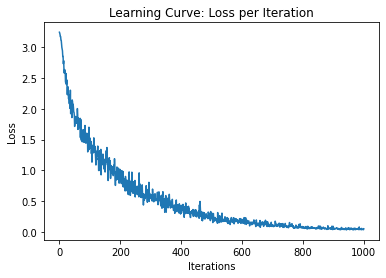

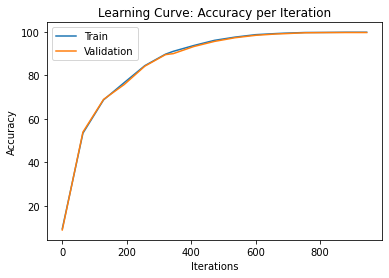

In [17]:
plot_learning_curve(iters, losses, iters_sub, train_accs, valid_accs)

Test set: Average loss: 0.437634, Accuracy: 89%


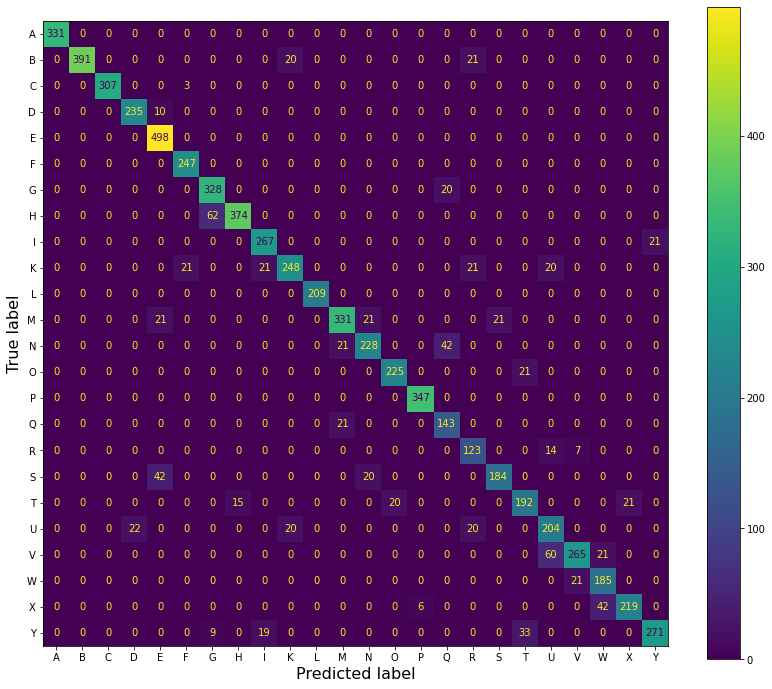

In [18]:
test_loss, test_acc, lenet_test_conf_mat = get_accuracy(model_lenet,loader=test_loader)
print("Test set: Average loss: %f, Accuracy: %.0f%%" % (test_loss,test_acc)) 
show_confusion_matrix(lenet_test_conf_mat)

We can see that this architecture did not improve the results significantly over our more basic CNN. 

## CapsNet

Capsule network (CapsNet) is an architecture introducted in a paper from 2017 [1]. This architecture is designed to mimic the segmentation in the biological structure of neurons, and more specifically, the neurons in charge of the vision.

Every layer in the network will be divided into groups called "capsules", where each one represents a processing unit of a certain propertry of an object in the image (such as texture, hue, pose, etc.).

In their paper, Hinton and his team showed that this architecture achieved a very high performance on the MNIST database, which was comaprable to much deeper convolutional neural networks. The difference between the results of CapsNet and CNNs was especially significant when the goal was to recognize overlapping digits.

Another advantage of this architecture, is the fact that it addresses the relative spatial position of different parts of the image. For example, in the case of face recognition, most CNN architecures work by identifying key features in the image such as eyes, mouth, and nose. However, if those different parts of the image were mixed like in a Picasso painting, these models will still identify it as a face, since those features appear in the image.

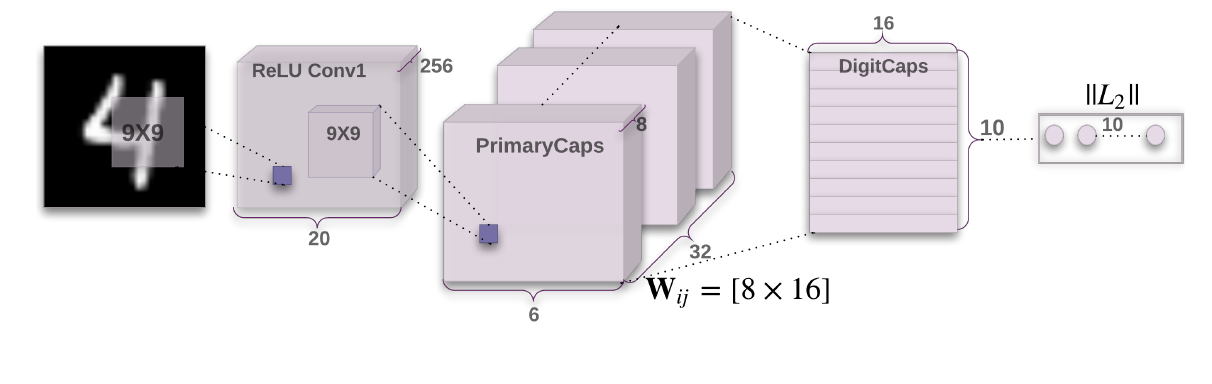
      *An illustration of a 3-layered CapsNet. Taken from the paper at [1].*



Here, we used the implementation of CapsNet by Jindong Wang and his team [2]. Several modifications were made in order to fit the model to 24 classes, and not 10 classes like MNIST, as well as changes of the hyperparameters.

In [19]:
from torch.autograd import Variable
from tqdm import tqdm

USE_CUDA = True if torch.cuda.is_available() else False
BATCH_SIZE = 64
N_EPOCHS = 4
LEARNING_RATE = 0.01
MOMENTUM = 0.9
n_features = 10
'''
Config class to determine the parameters for capsule net
'''

class Config:
    def __init__(self):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 256
        self.cnn_kernel_size = 9

        # Primary Capsule (pc)
        self.pc_num_capsules = 8
        self.pc_in_channels = 256
        self.pc_out_channels = 32
        self.pc_kernel_size = 9
        self.pc_num_routes = 32 * 6 * 6

        # Digit Capsule (dc)
        self.dc_num_capsules = 26
        self.dc_num_routes = 32 * 6 * 6
        self.dc_in_channels = 8
        self.dc_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28

from torch.autograd import Variable

USE_CUDA = True if torch.cuda.is_available() else False

class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=1
                              )

    def forward(self, x):
        return F.relu(self.conv(x))


class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9, num_routes=32 * 6 * 6):
        super(PrimaryCaps, self).__init__()
        self.num_routes = num_routes
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), self.num_routes, -1)
        return self.squash(u)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor


class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij, dim=1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)

            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor


class Decoder(nn.Module):
    def __init__(self, input_width=28, input_height=28, input_channel=1):
        super(Decoder, self).__init__()
        self.input_width = input_width
        self.input_height = input_height
        self.input_channel = input_channel
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 26, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, self.input_height * self.input_width * self.input_channel),
            nn.Sigmoid()
        )

    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes, dim=0)

        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(26))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=Variable(max_length_indices.squeeze(1).data))
        t = (x * masked[:, :, None, None]).view(x.size(0), -1)
        reconstructions = self.reconstraction_layers(t)
        reconstructions = reconstructions.view(-1, self.input_channel, self.input_width, self.input_height)
        return reconstructions, masked


class CapsNet(nn.Module):
    def __init__(self, config=None):
        super(CapsNet, self).__init__()
        if config:
            self.conv_layer = ConvLayer(config.cnn_in_channels, config.cnn_out_channels, config.cnn_kernel_size)
            self.primary_capsules = PrimaryCaps(config.pc_num_capsules, config.pc_in_channels, config.pc_out_channels,
                                                config.pc_kernel_size, config.pc_num_routes)
            self.digit_capsules = DigitCaps(config.dc_num_capsules, config.dc_num_routes, config.dc_in_channels,
                                            config.dc_out_channels)
            self.decoder = Decoder(config.input_width, config.input_height, config.cnn_in_channels)
        else:
            self.conv_layer = ConvLayer()
            self.primary_capsules = PrimaryCaps()
            self.digit_capsules = DigitCaps()
            self.decoder = Decoder()

        self.mse_loss = nn.MSELoss()

    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked

    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)

    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x ** 2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss

    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

def train_capsnet(model, optimizer, train_loader, epoch):
    capsule_net = model
    capsule_net.train()
    n_batch = len(list(enumerate(train_loader)))
    total_loss = 0
    n = 0 # the number of iterations
    train_accs, iters, iters_sub, losses = [], [], [], []
    for batch_id, ar in enumerate(train_loader):
        data = ar[:,1:].type(torch.double)
        target = ar[:,0].type(torch.int64)
        target = torch.sparse.torch.eye(26).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        data = data.view(-1, 28*28)
        data = data.view(-1, 1, 28, 28)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()
        correct = sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1))
        train_loss = loss.item()
        total_loss += train_loss
        iters.append(n)
        losses.append(loss.item())
        if batch_id % 100 == 0:
            current_acc, current_loss, _ = get_accuracy_capsnet(capsule_net, train_loader)
            iters_sub.append(n)
            train_accs.append(current_acc)
            # tqdm.write(
            #     "Epoch: [{}/{}], train accuracy: {:.6f}%, loss: {:.6f}".format(e, N_EPOCHS, valid_acc,
            #                                                               valid_loss / len(val_loader)))
            tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train accuracy: {:.6f}%, loss: {:.6f}".format(
                epoch,
                N_EPOCHS,
                batch_id + 1,
                n_batch,
                current_acc,
                current_loss
                ))
        n += 1
    tqdm.write('Epoch: [{}/{}], train loss: {:.6f}'.format(epoch,N_EPOCHS,total_loss / len(train_loader.dataset)))
    return train_accs, iters, iters_sub, losses

def get_accuracy_capsnet(capsule_net, loader):
    capsule_net.eval()
    final_loss = 0
    correct = 0

    pred_list = []
    true_list = []
    for batch_id, ar in enumerate(loader):
        data = ar[:,1:].type(torch.double)
        target = ar[:,0].type(torch.int64)
        target = torch.sparse.torch.eye(26).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        data = data.view(-1, 28*28)
        data = data.view(-1, 1, 28, 28)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        final_loss += loss.item()
        correct += sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                       np.argmax(target.data.cpu().numpy(), 1))
        
        for y in np.argmax(masked.data.cpu().numpy(), 1):
          pred_list.append(y)

        for y in np.argmax(target.data.cpu().numpy(), 1):  
          true_list.append(y)

    conf_mat = confusion_matrix(true_list, pred_list, labels=list(range(0,9))+list(range(10,25)))  
    acc = correct * 100 / len(loader.dataset)
    final_loss /= len(loader.dataset)
    return acc, final_loss, conf_mat

Again, we'll train the model and print its performance:

In [ ]:
import gc

gc.collect()

torch.manual_seed(1)
config = Config()

capsule_net = CapsNet(config)
capsule_net = torch.nn.DataParallel(capsule_net)
if USE_CUDA:
    capsule_net = capsule_net.cuda()
capsule_net = capsule_net.module.double()
torch.cuda.empty_cache()
optimizer = torch.optim.Adam(capsule_net.parameters())
for e in range(1, N_EPOCHS + 1):
    train_accs, iters, iters_sub, train_losses = train_capsnet(capsule_net, optimizer, train_loader, e)
    valid_acc, valid_loss, _ = get_accuracy_capsnet(capsule_net, val_loader)
    tqdm.write(
        "Epoch: [{}/{}], validation accuracy: {:.6f}%, loss: {:.6f}".format(e, N_EPOCHS, valid_acc,
                                                                  valid_loss / len(val_loader)))

torch.save(capsule_net.state_dict(),  "/content/gdrive/My Drive/Intro_to_Deep_Learning/Project/capsnet.pt")

Epoch: [1/4], Batch: [1/344], train accuracy: 14.824258%, loss: 0.013825
Epoch: [1/4], Batch: [101/344], train accuracy: 90.115644%, loss: 0.010264
Epoch: [1/4], Batch: [201/344], train accuracy: 97.942087%, loss: 0.007555
Epoch: [1/4], Batch: [301/344], train accuracy: 99.594791%, loss: 0.005868
Epoch: [1/4], train loss: 0.009014
Epoch: [1/4], validation accuracy: 99.799672%, loss: 0.000070
Epoch: [2/4], Batch: [1/344], train accuracy: 99.694955%, loss: 0.005978
Epoch: [2/4], Batch: [101/344], train accuracy: 99.927154%, loss: 0.003531
Epoch: [2/4], Batch: [201/344], train accuracy: 99.872519%, loss: 0.005180
Epoch: [2/4], Batch: [301/344], train accuracy: 99.908942%, loss: 0.002916
Epoch: [2/4], train loss: 0.004823
Epoch: [2/4], validation accuracy: 99.908942%, loss: 0.000026
Epoch: [3/4], Batch: [1/344], train accuracy: 99.922601%, loss: 0.002045
Epoch: [3/4], Batch: [101/344], train accuracy: 99.990894%, loss: 0.000906
Epoch: [3/4], Batch: [201/344], train accuracy: 100.000000%, l

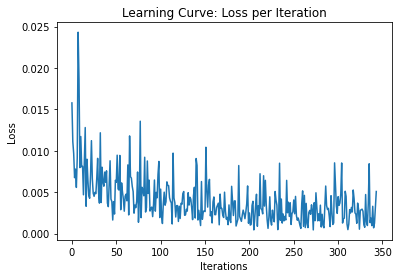

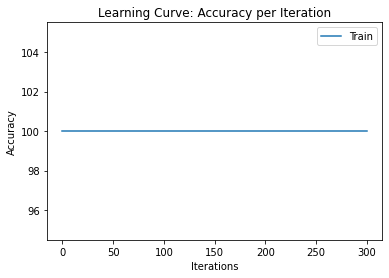

In [ ]:
plot_learning_curve(iters, train_losses, iters_sub, train_accs, [])

Training the CapsNet model takes signifacntly more time than training the previous CNNs. Therefore, it's important to save the model's state dictionary so we can load it later.

In [ ]:
from datetime import datetime

now = datetime.now() 
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

torch.save(capsule_net.state_dict(),  "/content/gdrive/My Drive/Intro_to_Deep_Learning/Project/capsnet_" + dt_string + ".pt")

test accuracy: 94.143893%, loss: 0.000045


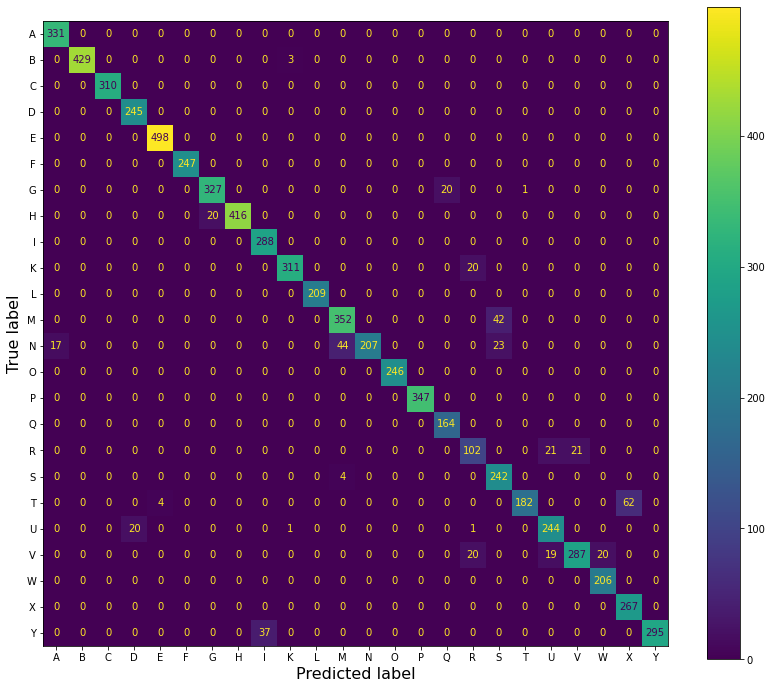

In [21]:
gc.collect()
torch.cuda.empty_cache()

torch.manual_seed(1)
config = Config()

capsule_net = CapsNet(config)
capsule_net = torch.nn.DataParallel(capsule_net)
if USE_CUDA:
    capsule_net = capsule_net.cuda()
capsule_net = capsule_net.module.double()
capsule_net.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/Project/capsnet_12_01_2022_12_55_38.pt'))
torch.cuda.empty_cache()
test_acc, test_loss, capsnet_test_conf_mat = get_accuracy_capsnet(capsule_net, test_loader)
tqdm.write(
    "test accuracy: {:.6f}%, loss: {:.6f}".format(test_acc, test_loss / len(test_loader)))
show_confusion_matrix(capsnet_test_conf_mat)

We can see that the performance of this model is significantly hgiher that the previous ones. On the other hand, it is more complicated and training it took a longer time.

## Results Analysis



In order to analize our results further, we'll define a function which will show us recurring results between the 3 confusion matrices we have.

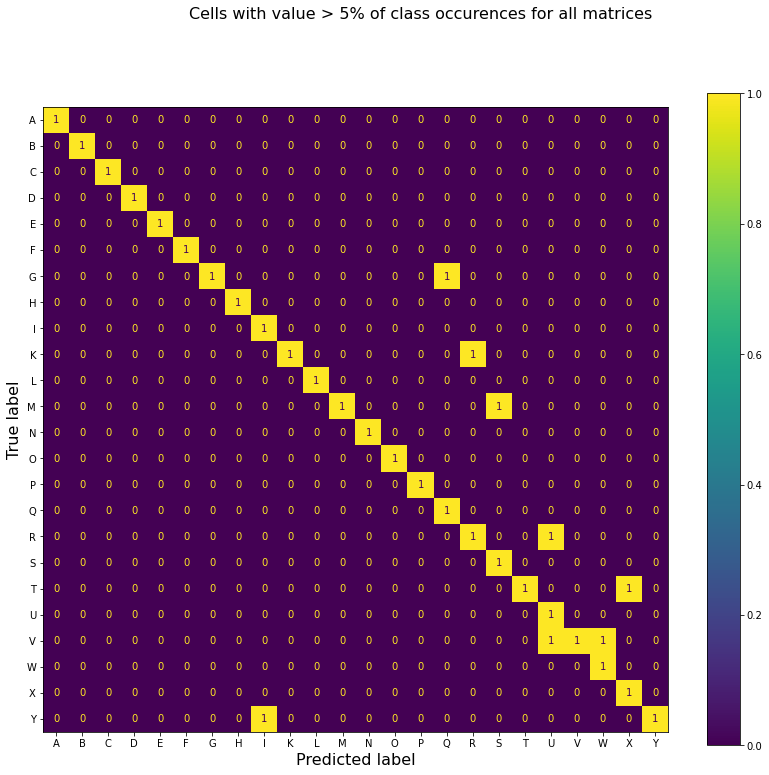

In [87]:
def mismatch_per(conf_mat, x, y):
  num_of_occurences = np.sum(conf_mat[x,:])
  return conf_mat[x,y] * 100 / num_of_occurences

def show_cells_with_high__values(conf_mat1, conf_mat2, conf_mat3, th = 5):
  confusing_pairs = []
  mat = np.zeros(conf_mat1.shape)
  display_labels=[alphabet_dict[i] for i in list(range(0,9))+list(range(10,25))]
  for x in range(0, conf_mat1.shape[0]):
    for y in range(0, conf_mat1.shape[1]):     
      if (mismatch_per(conf_mat1,x,y) >= th) and (mismatch_per(conf_mat2,x,y) >= th) and (mismatch_per(conf_mat3,x,y) >= th):
        mat[x,y] = 1
        if x != y:
          confusing_pairs.append([display_labels[x], display_labels[y]])

  disp = ConfusionMatrixDisplay(mat, display_labels=display_labels)
  fig, ax = plt.subplots(figsize=(14, 12))
  ax.set_xlabel('Preicted Label', fontsize=16)
  ax.set_ylabel('True Label', fontsize=16) 
  fig.suptitle(f"Cells with value > {th}% of class occurences for all matrices", fontsize=16)
  disp.plot(ax=ax)

  return confusing_pairs

confusing_pairs = show_cells_with_high__values(cnn_test_conf_mat, lenet_test_conf_mat, capsnet_test_conf_mat)

In the above matrix, if a cell has a value of 1, it means that in all 3 confusion matrices the corresponding cell has a value of 5% or more of the total number of occurences for the class. This could indicate that a specific class is likely to be confused with another. Next, we'll display images of letter gestures for cells with a value of 1 which are not on the main diagonal. These are letter pair for which the models had a relatively low performance. It is worth noting that the matrices are not symetric, meaning that if a certain model frequently classified a letter of label $L_1$ as label $L_2$, it does not mean that it frequently classified  a letter of label $L_2$ as label $L_1$.

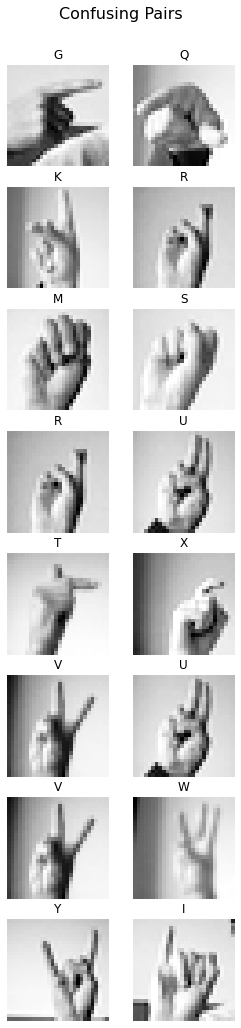

In [130]:
import matplotlib.gridspec as gridspec

def get_confusing_pair(letters):
  imgs = []
  for i in [0,1]:
    idx = 0
    letter = letters[i]
    letter_not_found = True
    while letter_not_found:
      if (alphabet_dict[int(t_test[idx])] == letter):
        letter_not_found = False
        imgs.append(x_test_norm[idx])
      idx += 1
  return imgs    

fig, axs = plt.subplots(len(confusing_pairs), 2, figsize=(2*len(confusing_pairs), 2*len(confusing_pairs)))
fig.suptitle('Confusing Pairs', fontsize=16)

for pair_idx in range(0,len(confusing_pairs)):
  pair = confusing_pairs[pair_idx]
  pair_imgs = get_confusing_pair(pair)

  img1 = np.reshape(pair_imgs[0], (28, 28))
  # plt.imshow(img1, cmap='Greys_r')
  img2 = np.reshape(pair_imgs[1], (28, 28))
  # plt.imshow(img2, cmap='Greys_r')

  axs[pair_idx,0].imshow(img1, cmap='Greys_r')
  axs[pair_idx,0].axis('off')
  axs[pair_idx,0].set_title(pair[0])
  axs[pair_idx,1].imshow(img2, cmap='Greys_r')
  axs[pair_idx,1].set_title(pair[1])
  axs[pair_idx,1].axis('off')

# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.2, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.4)
# plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.subplots_adjust(bottom=0.1, left=0.4, right=0.6, top = 0.93)
plt.show()

By looking at the images, it is easy to see why most of these pairs confused the models.

## References

[1] Y. LeCun, L. Bottou, Y. Bengio, P. Haffner et al., “Gradient-based
learning applied to document recognition,” Proceedings of the IEEE,
vol. 86, no. 11, pp. 2278–2324, 1998.

[2] https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/

[3] S. Sabour, N. Frosst, and G. E. Hinton, “Dynamic routing between
capsules,” in Advances in neural information processing systems, 2017,
pp. 3856–3866.

[4] https://github.com/jindongwang/Pytorch-CapsuleNet